In [1]:
import pandas as pd
import numpy as np
import dtale
import sweetviz as sv
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# from pandas_profiling import ProfileReport
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# first_demo is the Facebook supplied test data, second_demo was created from the largest relevant data we have.
first_demo = pd.read_csv('C:/Users/norri/Desktop/dt_simulated.csv')
second_demo = pd.read_csv('C:/Users/norri/Desktop/roybn_sheet_1.csv')
first_demo.round(2)
second_demo.round(2)

,DATE,banner_I,coupon_I,sm_I,in_store_I,pos_I,radio_I,circular_I,dig_ad_I,banner_S,coupon_S,sm_S,in_store_S,pos_S,radio_S,circular_S,dig_ad_S,revenue
0,2019-09-30,21870.0,11557.0,14091.0,NaN,9173.0,NaN,NaN,1234027.0,1337220.0,109572.79,145157.75,NaN,1592472.13,NaN,NaN,1.111341e+08,1092106.53
1,2019-10-07,NaN,NaN,NaN,NaN,27754.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127663.51,NaN,NaN,NaN,127663.51
2,2019-10-14,34453.0,NaN,NaN,NaN,NaN,NaN,18955.0,242862.0,NaN,NaN,NaN,NaN,NaN,NaN,242861.91,1.678222e+07,242861.91
3,2019-10-21,10000.0,NaN,NaN,NaN,16003.0,NaN,NaN,96500.0,NaN,NaN,NaN,NaN,96499.57,NaN,NaN,5.031058e+07,96499.57
4,2019-10-28,18074.0,NaN,NaN,NaN,27122.0,NaN,NaN,48352.0,NaN,NaN,NaN,NaN,92308.41,NaN,NaN,4.012728e+07,73711.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,2022-06-13,NaN,NaN,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,847637.21,NaN,NaN,NaN,NaN,NaN,8.476372e+05,847637.21
142,2022-06-20,NaN,NaN,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,518896.90,NaN,NaN,NaN,NaN,NaN,5.188969e+05,518896.90
143,2022-06-27,54000.0,NaN,NaN,NaN,34679.0,NaN,NaN,6531.0,408226.0,NaN,NaN,61516.24,NaN,NaN,76882245.00,2.696325e+05,269632.47
144,2022-07-04,NaN,NaN,NaN,NaN,15325.0,NaN,NaN,NaN,NaN,NaN,NaN,2011.05,NaN,NaN,NaN,2.011050e+03,2011.05


I initially compared the first weekly demo data from Robyn with the most recent, which they were. There have been a few changes to the program, it seems, but not the data. There was one thing of note:  if you examined the correlation between revenue and competitor_sales_B, it was the only high correlation, and in experiment 2, when we dropped it, the entire model changed for the worse.

On a side note, D-Tale and SweetViz are fantastic EDA tools, with a few interactive functions, but SweetViz will open a new browser window for every run it makes.

In [3]:
dtale.show(first_demo) # note the predictive power score for revenue: it's the only scored variable at all and it's at .63

In [4]:
dtale.show(second_demo) # there are quite a few more correlated variables with revenue, but nothing much about .5.

SweetViz can tell you a great deal about the numerical variables in your data, as well as provide an 'Associations' tab much like a correlation plot.

In [5]:
sweet_report = sv.analyze(first_demo)
sweet_report.show_html('sweet_report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report sweet_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


The accuracy of this report is certainly affected by all the missing values, but we can compare it to the data after we impute the missings.

In [6]:
sweet_report_2 = sv.analyze(second_demo)
sweet_report_2.show_html('sweet_report_2.html')

                                             |          | [  0%]   00:00 -> (? left)

C:\Users\norri\anaconda3\lib\site-packages\numpy\lib\function_base.py:2683: RuntimeWarning:

Degrees of freedom <= 0 for slice



Report sweet_report_2.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
---
(likely due to only a single row containing non-NaN values for both correlated features)
Affected correlations:['sm_S/in_store_S', 'in_store_S/sm_S']


Because of the missing_values, the comparison between the two datasets is not of much use as of yet.

In [7]:
sweet_report_3 = sv.compare(first_demo, second_demo)
sweet_report_3.show_html('sweet_report_3.html')

                                             |          | [  0%]   00:00 -> (? left)

Report sweet_report_3.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


To give you a better impression of how much missing data there is, I provided the actual missing values, out of 146, the percentage of missing values, and the average of the percentage missing.

In [8]:
second_demo.isnull().sum()

DATE            0
banner_I       63
coupon_I       98
sm_I          103
in_store_I    133
pos_I          91
radio_I       142
circular_I    130
dig_ad_I       63
banner_S       99
coupon_S       88
sm_S          121
in_store_S    119
pos_S         110
radio_S       138
circular_S    104
dig_ad_S       41
revenue         0
dtype: int64

In [9]:
missing_values = second_demo.isnull().sum()
print(missing_values/146)

DATE          0.000000
banner_I      0.431507
coupon_I      0.671233
sm_I          0.705479
in_store_I    0.910959
pos_I         0.623288
radio_I       0.972603
circular_I    0.890411
dig_ad_I      0.431507
banner_S      0.678082
coupon_S      0.602740
sm_S          0.828767
in_store_S    0.815068
pos_S         0.753425
radio_S       0.945205
circular_S    0.712329
dig_ad_S      0.280822
revenue       0.000000
dtype: float64


In [10]:
print(np.average(missing_values/146))

0.6251902587519026


,banner_I,coupon_I,sm_I,in_store_I,pos_I,radio_I,circular_I,dig_ad_I,banner_S,coupon_S,sm_S,in_store_S,pos_S,radio_S,circular_S,dig_ad_S,revenue
count,17.000000,16.000000,16.000000,15.000000,16.000000,8.000000,15.000000,17.000000,15.000000,16.000000,14.000000,16.000000,15.000000,15.000000,16.000000,17.000000,17.000000
mean,0.408824,0.473750,0.071250,0.518000,0.125625,0.800000,-0.108000,0.462941,0.326000,0.388125,0.413571,0.358125,0.108667,0.458667,0.221875,0.274118,0.495294
std,0.316443,0.322612,0.488342,0.472141,0.412714,0.370328,0.573152,0.409004,0.389612,0.438592,0.401336,0.548297,0.589344,0.635856,0.330721,0.377426,0.328388
min,-0.330000,0.000000,-1.000000,-0.770000,-0.460000,0.200000,-0.870000,-0.670000,-0.300000,-0.740000,-0.460000,-1.000000,-1.000000,-1.000000,-0.500000,-0.370000,-0.150000
25%,0.260000,0.215000,-0.112500,0.330000,-0.120000,0.800000,-0.540000,0.340000,0.055000,0.085000,0.335000,0.157500,-0.105000,0.230000,0.022500,-0.010000,0.200000
50%,0.410000,0.515000,0.200000,0.400000,-0.020000,1.000000,-0.150000,0.460000,0.240000,0.450000,0.440000,0.520000,0.160000,0.600000,0.240000,0.260000,0.550000
75%,0.540000,0.625000,0.322500,0.935000,0.335000,1.000000,0.115000,0.720000,0.465000,0.625000,0.630000,0.732500,0.490000,1.000000,0.397500,0.400000,0.770000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


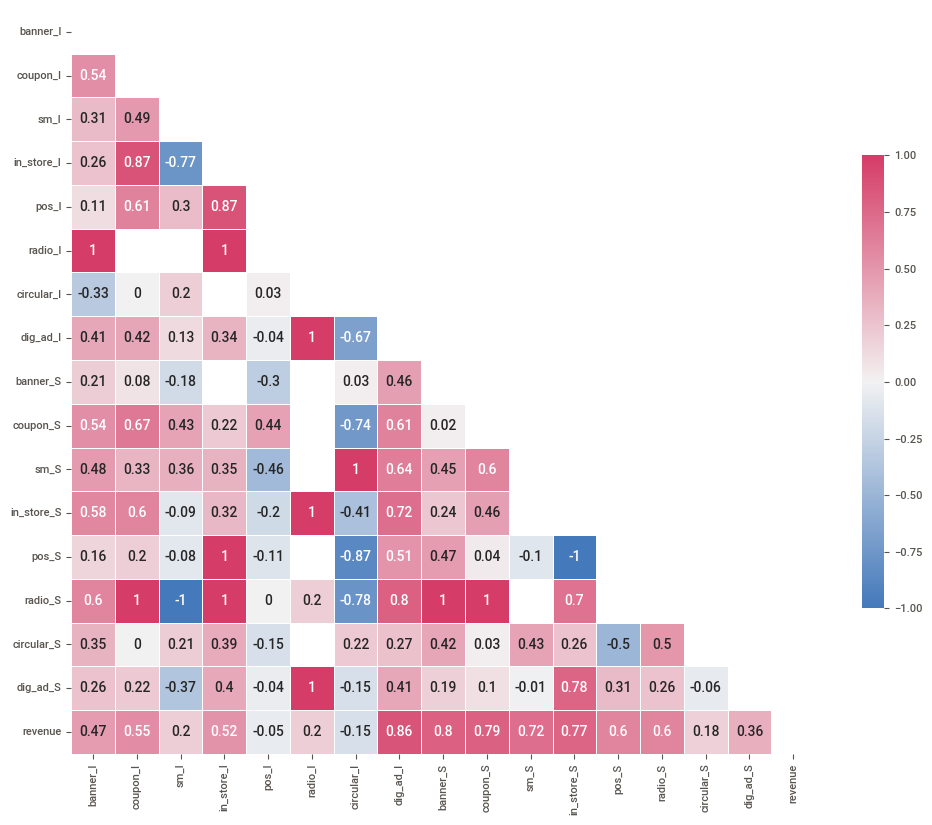

In [11]:
corr = second_demo.corr(method="spearman").round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.diverging_palette(250, 1, as_cmap=True)
sns.heatmap(corr, annot=True, cmap=cmap, mask=mask, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr.describe()

Here I begin the process of imputing missing values. I have to split the date off for this method to work.

In [12]:
second_demo['ID'] = second_demo.reset_index().index
date_split = second_demo[['DATE']]
imp_split = second_demo.drop(['DATE'], axis=1)
date_split['ID'] = imp_split['ID']
col_names = list(imp_split.columns)

C:\Users\norri\AppData\Local\Temp\ipykernel_23404\1214819989.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
imp_split.to_numpy().astype(np.int32)

array([[      21870,       11557,       14091, ...,   111134070,
            1092106,           0],
       [-2147483648, -2147483648, -2147483648, ..., -2147483648,
             127663,           1],
       [      34453, -2147483648, -2147483648, ...,    16782220,
             242861,           2],
       ...,
       [      54000, -2147483648, -2147483648, ...,      269632,
             269632,         143],
       [-2147483648, -2147483648, -2147483648, ...,        2011,
               2011,         144],
       [      10000,       15000, -2147483648, ...,      164332,
             164332,         145]])

IterativeImputer is one of the newest imputation MLs out, and it is very resource intensive. It's imputations are supposed to be excellent, but you can only do so much with so much missing data.

In [14]:
it_imp = IterativeImputer(random_state=42, max_iter=5,
                          min_value=500, max_value=45000, verbose=2)
it_imp.fit(imp_split)
imputed = it_imp.transform(imp_split)

[IterativeImputer] Completing matrix with shape (146, 18)
[IterativeImputer] Ending imputation round 1/5, elapsed time 0.07
[IterativeImputer] Change: 340016006.08482057, scaled tolerance: 4320024.906 
[IterativeImputer] Ending imputation round 2/5, elapsed time 0.09
[IterativeImputer] Change: 109266.0682861441, scaled tolerance: 4320024.906 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (146, 18)
[IterativeImputer] Ending imputation round 1/2, elapsed time 0.00
[IterativeImputer] Ending imputation round 2/2, elapsed time 0.00


I merged the dates back in, and as you can see, the missing values are gone, and they all look pretty reasonable. I'll repeat most of the tests I ran earlier to see if there's anything not obvious.

In [15]:
second_demo = pd.DataFrame(imputed, columns=col_names)
second_demo = second_demo.set_axis(col_names, axis=1)
second_demo = pd.merge(second_demo, date_split, how='inner')
second_demo = second_demo.drop(['ID'], axis=1)
round(second_demo, 2)

,banner_I,coupon_I,sm_I,in_store_I,pos_I,radio_I,circular_I,dig_ad_I,banner_S,coupon_S,sm_S,in_store_S,pos_S,radio_S,circular_S,dig_ad_S,revenue,DATE
0,21870.00,11557.00,14091.00,24850.27,9173.00,500.00,26175.89,1234027.0,1337220.0,109572.79,145157.75,500.00,1592472.13,500.0,45000.00,1.111341e+08,1092106.53,2019-09-30
1,23708.26,14110.45,17310.79,2771.09,27754.00,3122.18,26907.00,45000.0,45000.0,45000.00,45000.00,500.00,127663.51,45000.0,45000.00,4.500000e+04,127663.51,2019-10-07
2,34453.00,15922.56,17368.07,6114.82,17788.86,3009.18,18955.00,242862.0,45000.0,45000.00,45000.00,33971.80,45000.00,45000.0,242861.91,1.678222e+07,242861.91,2019-10-14
3,10000.00,15623.77,17105.36,12814.50,16003.00,4409.80,26591.77,96500.0,45000.0,45000.00,45000.00,500.00,96499.57,45000.0,45000.00,5.031058e+07,96499.57,2019-10-21
4,18074.00,15144.02,17132.63,10780.78,27122.00,4151.39,26656.60,48352.0,45000.0,45000.00,45000.00,500.00,92308.41,45000.0,45000.00,4.012728e+07,73711.27,2019-10-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,24377.88,23372.89,15000.00,2897.55,17888.94,10554.08,26884.85,45000.0,45000.0,847637.21,45000.00,45000.00,45000.00,45000.0,45000.00,8.476372e+05,847637.21,2022-06-13
142,24088.18,19498.65,15000.00,2845.65,17876.83,7592.66,26894.73,45000.0,45000.0,518896.90,45000.00,45000.00,45000.00,45000.0,45000.00,5.188969e+05,518896.90,2022-06-20
143,54000.00,20513.09,18649.11,4169.02,34679.00,500.00,25366.57,6531.0,408226.0,45000.00,45000.00,61516.24,500.00,45000.0,76882245.00,2.696325e+05,269632.47,2022-06-27
144,23589.74,13364.13,17298.22,2765.25,15325.00,3237.83,26909.85,500.0,45000.0,45000.00,31934.27,2011.05,45000.00,45000.0,45000.00,2.011050e+03,2011.05,2022-07-04


In [16]:
dtale.show(second_demo) # the revenue correlations look much more reasonable, with all of the present, but only banner spend breaking .5. Also, the power analysis doesn't reveal anything strange towards revenue.

The histograms look more normal, and the 'Associations' plot actually works this time, but there are some warnings that the calculations are a bit off.

In [17]:
sweet_report_4 = sv.analyze(second_demo)
sweet_report_4.show_html('sweet_report_4.html')

                                             |          | [  0%]   00:00 -> (? left)

Report sweet_report_4.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Similar to the plot above, this is to compare how everything changed after imputation.

While I can't run all the same tests on Tyson data or Robyn, I will be doing comparisons. I filled the missings with zeroes for this dataset before the imputation, and will run both in Robyn to see how they perform. For Tyson data, I'll drop any variables that would not be useful to Robyn, and examine the quality that is left.

,banner_I,coupon_I,sm_I,in_store_I,pos_I,radio_I,circular_I,dig_ad_I,banner_S,coupon_S,sm_S,in_store_S,pos_S,radio_S,circular_S,dig_ad_S,revenue
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,0.215294,0.236471,0.032941,0.133529,0.013529,0.167059,-0.124706,0.262353,0.125882,0.210588,0.102941,0.198235,0.051176,0.104706,0.020000,0.192353,0.275294
std,0.279332,0.296605,0.315233,0.359617,0.293448,0.325476,0.378453,0.342646,0.292277,0.259987,0.265230,0.306966,0.344218,0.254807,0.394256,0.368248,0.332662
min,-0.330000,-0.300000,-0.420000,-0.520000,-0.290000,-0.620000,-0.590000,-0.520000,-0.290000,-0.170000,-0.210000,-0.240000,-0.650000,-0.110000,-0.650000,-0.450000,-0.300000
25%,0.160000,0.110000,-0.150000,-0.020000,-0.160000,0.080000,-0.330000,0.090000,-0.040000,0.090000,-0.020000,-0.030000,-0.040000,-0.040000,-0.150000,-0.040000,0.080000
50%,0.200000,0.230000,-0.010000,0.080000,-0.010000,0.170000,-0.160000,0.270000,0.150000,0.150000,0.060000,0.220000,-0.010000,0.070000,0.110000,0.170000,0.240000
75%,0.270000,0.360000,0.140000,0.160000,0.080000,0.240000,-0.030000,0.450000,0.230000,0.250000,0.130000,0.270000,0.150000,0.110000,0.170000,0.270000,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


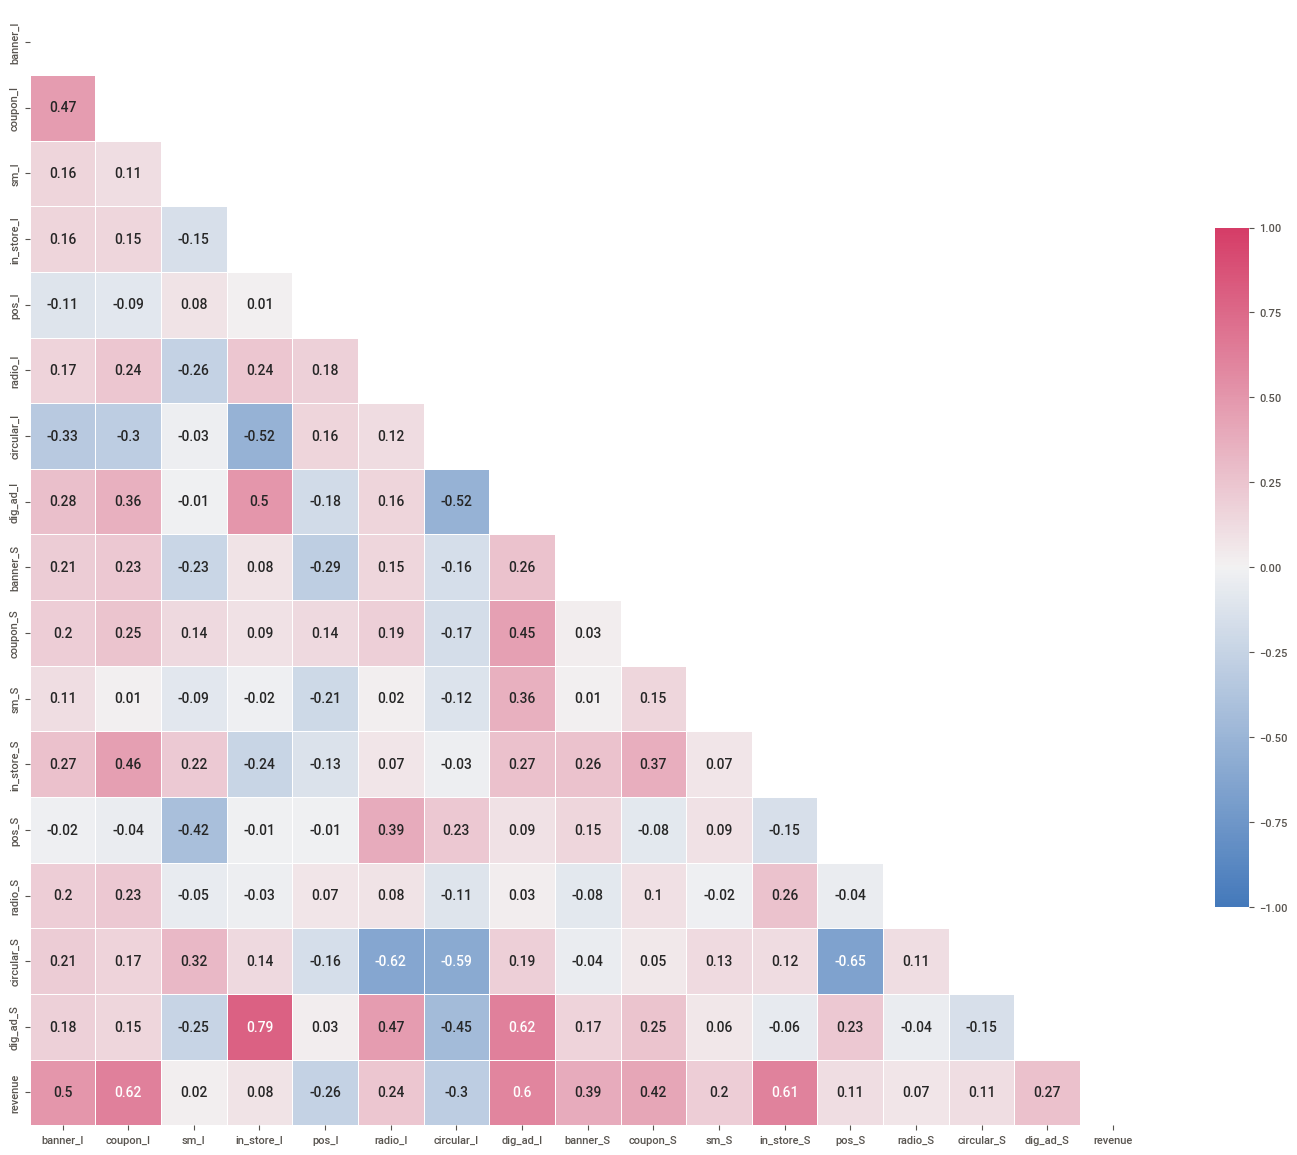

In [18]:
corr = second_demo.corr(method="spearman").round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(250, 1, as_cmap=True)
ax = sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr.describe()

Though there's not universal agreement, most agree that a VIF of 1 is not correlated, between 1 and 5 moderately correlated, and greater than 5 highly correlated. Robyn uses ridge regression, which does deflate the coefficients of high VIF variables, but since we have limited spots in our Robyn model, it could be a good criteria for elimination.

In [56]:
temp_split = second_demo.drop(['DATE'], axis=1)
vif_df = temp_split[~temp_split.isin([np.nan, np.inf, -np.inf]).any(1)]
X = vif_df
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

       feature       VIF
0     coupon_I  4.854759
1         sm_I  3.654714
2   in_store_I  2.490093
3   circular_I  2.214383
4     dig_ad_I  1.546014
5     coupon_S  2.328049
6         sm_S  1.447833
7   in_store_S  2.334687
8   circular_S  1.992957
9     dig_ad_S  2.102700
10     revenue  1.725858


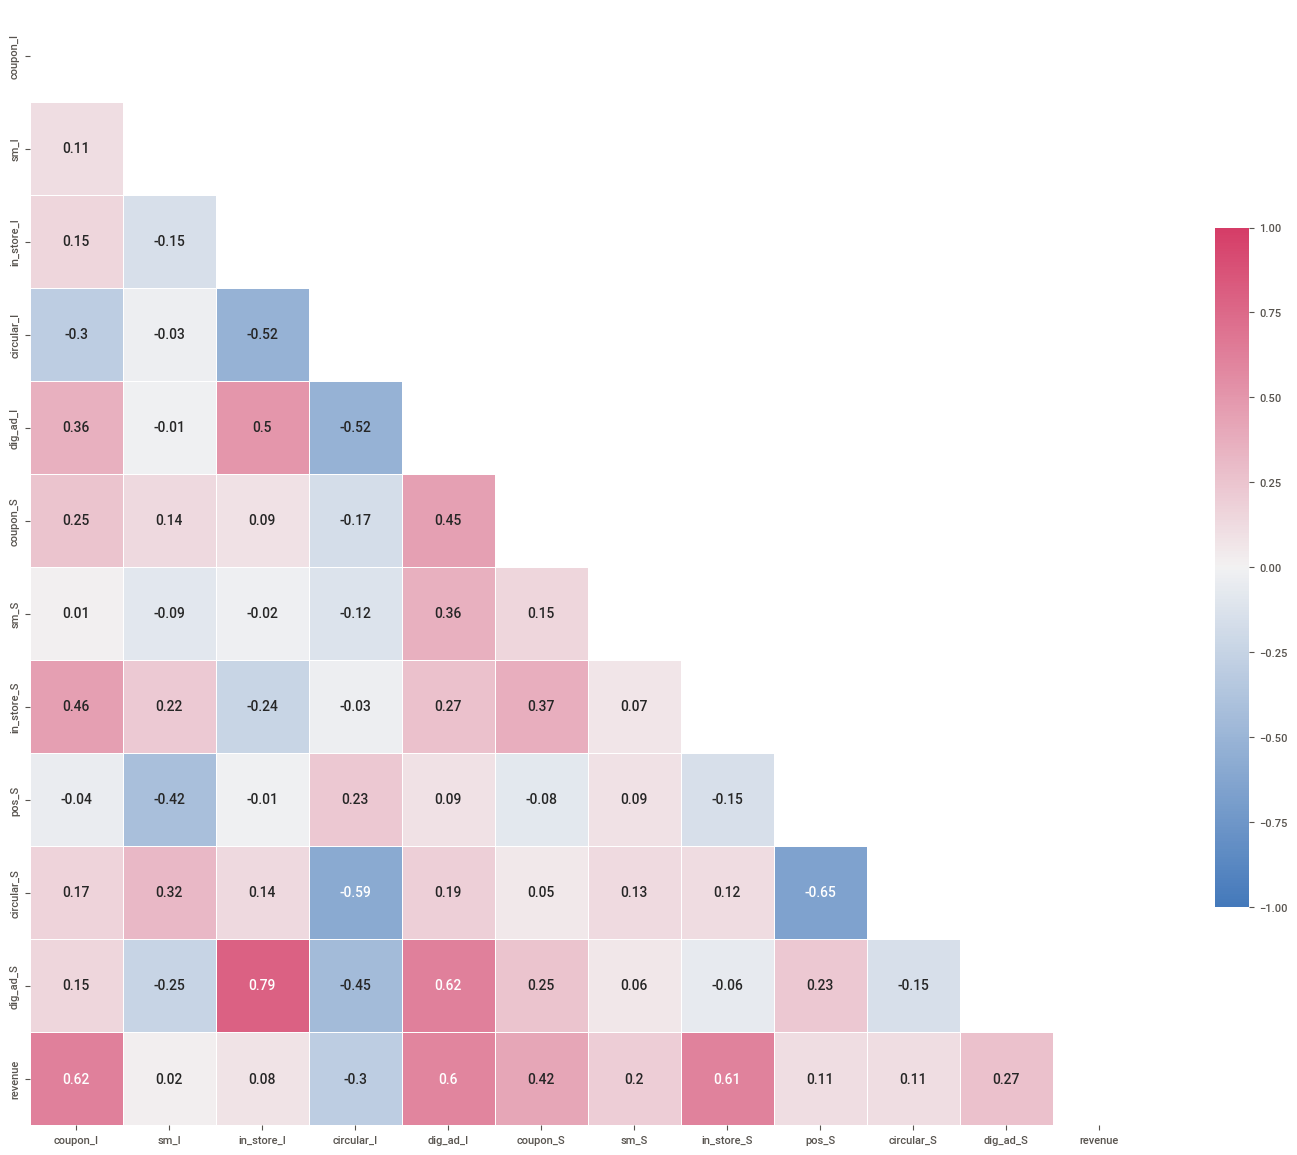

In [55]:
corr_vif = vif_df.corr(method="spearman").round(2)
mask = np.triu(np.ones_like(corr_vif, dtype=bool))
plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(250, 1, as_cmap=True)
sns.heatmap(corr_vif, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
# second_demo = second_demo.drop(['pos_S'], axis=1)

First I dropped radio_I with a VIF of 17. Then continued for any value over 5, especially an already dropped partner

In [57]:
corr = second_demo.corr(method="pearson")
corr.style.background_gradient(cmap="coolwarm").set_precision(2)

C:\Users\norri\AppData\Local\Temp\ipykernel_23404\3049163592.py:2: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



,coupon_I,sm_I,in_store_I,circular_I,dig_ad_I,coupon_S,sm_S,in_store_S,circular_S,dig_ad_S,revenue
coupon_I,1.00,0.06,0.62,-0.13,0.38,0.57,-0.02,0.51,0.27,0.56,0.45
sm_I,0.06,1.00,-0.05,-0.02,0.11,0.24,0.17,0.25,0.39,-0.19,0.00
in_store_I,0.62,-0.05,1.00,-0.09,0.35,0.42,0.02,0.51,0.01,0.48,0.20
circular_I,-0.13,-0.02,-0.09,1.00,-0.09,-0.09,-0.00,-0.06,-0.15,-0.15,-0.05
dig_ad_I,0.38,0.11,0.35,-0.09,1.00,0.39,-0.02,0.31,0.15,0.32,0.33
coupon_S,0.57,0.24,0.42,-0.09,0.39,1.00,0.07,0.44,-0.01,0.45,0.32
sm_S,-0.02,0.17,0.02,-0.00,-0.02,0.07,1.00,-0.04,0.02,0.12,0.00
in_store_S,0.51,0.25,0.51,-0.06,0.31,0.44,-0.04,1.00,0.42,0.14,0.24
circular_S,0.27,0.39,0.01,-0.15,0.15,-0.01,0.02,0.42,1.00,-0.07,0.05
dig_ad_S,0.56,-0.19,0.48,-0.15,0.32,0.45,0.12,0.14,-0.07,1.00,0.19


I found the density plots to be fairly normal with normalization, but there were a few in the impressions sections shifted to the right significantly.

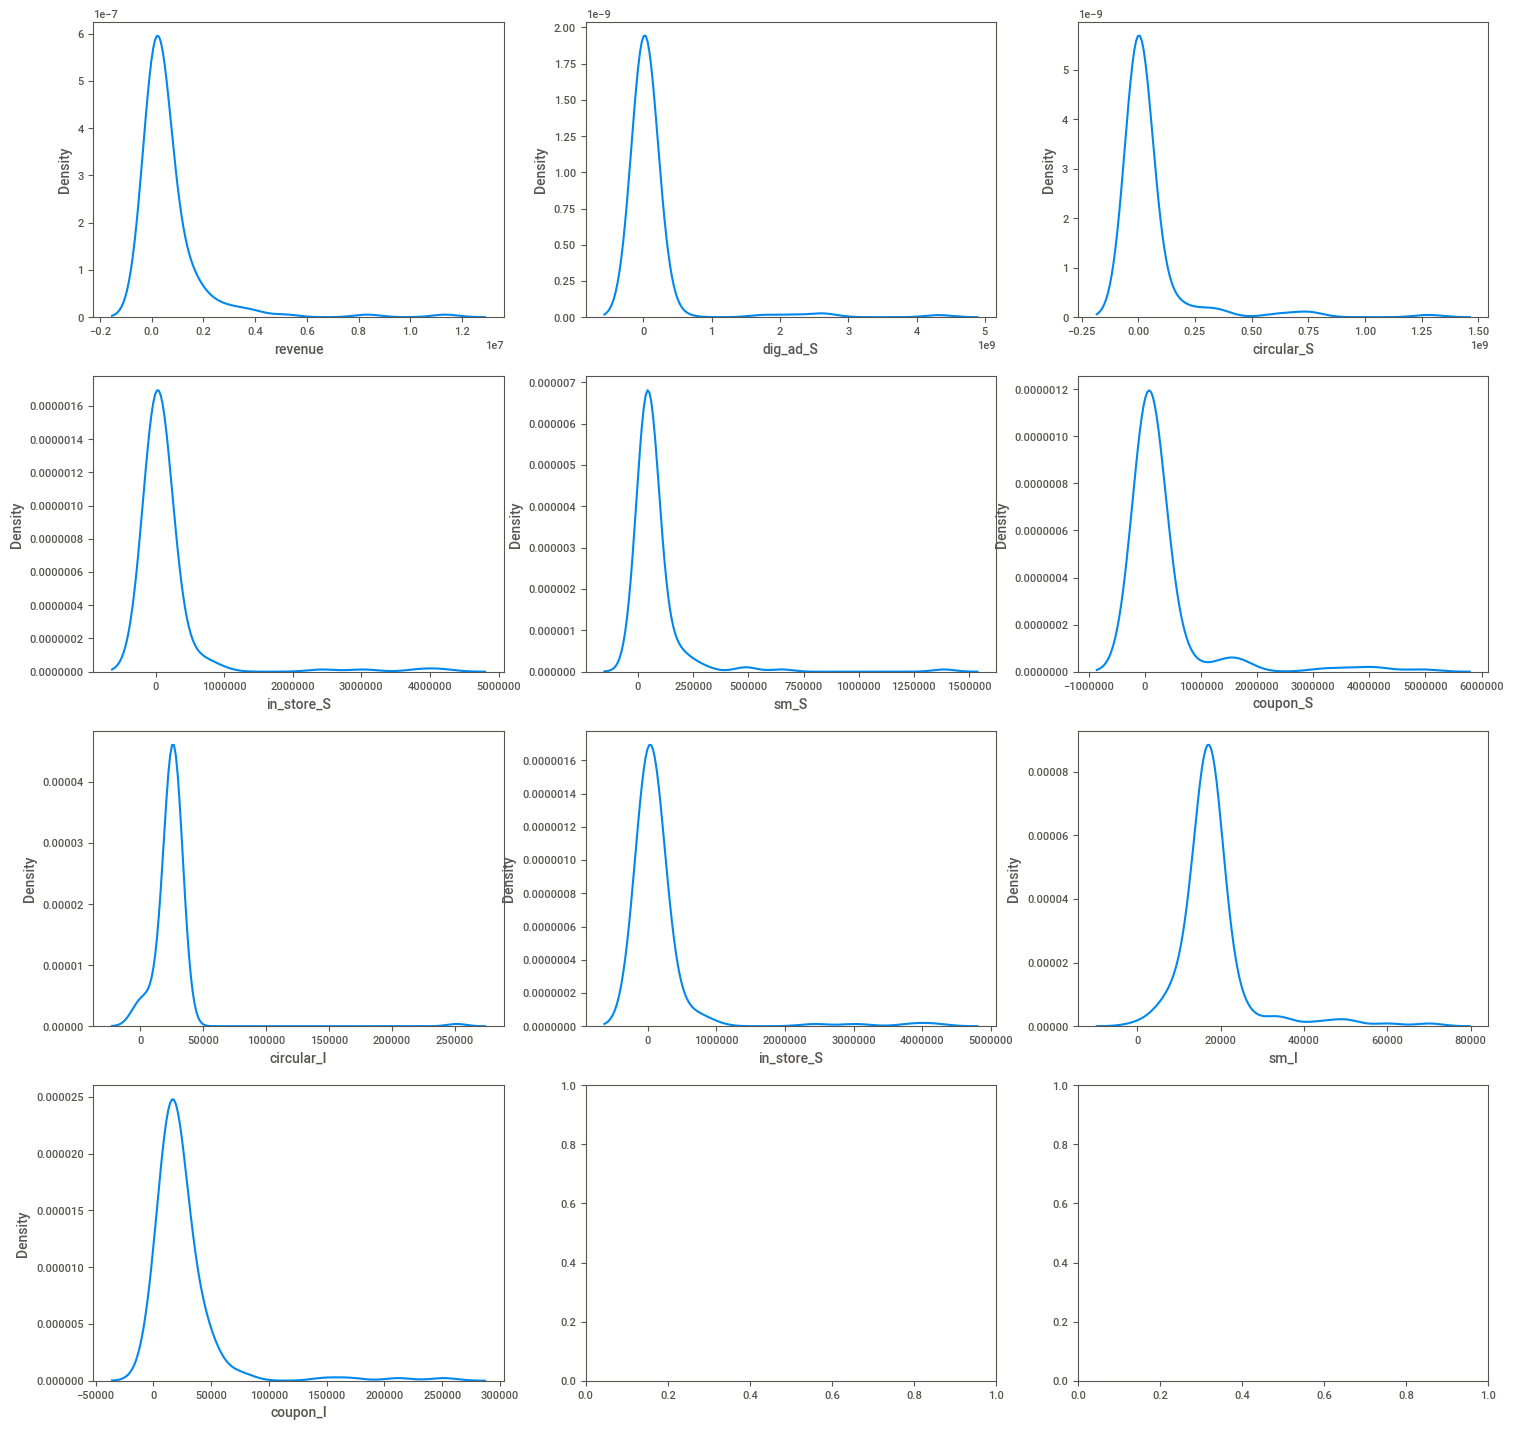

In [63]:
figure, axes = plt.subplots(4, 3, figsize=(18, 18))
sns.kdeplot(ax=axes[0, 0], x='revenue', data=second_demo)
sns.kdeplot(ax=axes[0, 1], x='dig_ad_S', data=second_demo)
sns.kdeplot(ax=axes[0, 2], x='circular_S', data=second_demo)
sns.kdeplot(ax=axes[1, 0], x='in_store_S', data=second_demo)
sns.kdeplot(ax=axes[1, 1], x='sm_S', data=second_demo)
sns.kdeplot(ax=axes[1, 2], x='coupon_S', data=second_demo)
sns.kdeplot(ax=axes[2, 0], x='circular_I', data=second_demo)
sns.kdeplot(ax=axes[2, 1], x='in_store_S', data=second_demo)
sns.kdeplot(ax=axes[2, 2], x='sm_I', data=second_demo)
sns.kdeplot(ax=axes[3, 0], x='coupon_I', data=second_demo)
plt.show()

In [64]:
second_demo.to_csv('robyn_test.csv', index=False)